In [1]:
from datasets.vc_clothes_data_module import VCClothesDataModule

from models.face_feature_extractor import FaceFeatureExtractor
from models.appearance_branch import AppearanceBranch
from models.fusion_module import FusionModule


import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

from plot_metrics import get_test_metricies

In [2]:
DATA_ROOT = "./data/vc_clothes"
BATCH_SIZE = 128

EMBEDING_DIM = 512

In [3]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device name: {torch.cuda.get_device_name(0)}")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.set_float32_matmul_precision("medium")

PyTorch version: 2.9.1+cu130
CUDA available: True
Device name: NVIDIA GeForce RTX 5060 Ti


In [4]:
dm = VCClothesDataModule(root_dir=DATA_ROOT, batch_size=BATCH_SIZE, num_workers=5)

face_branch = FaceFeatureExtractor(embedding_dim=EMBEDING_DIM)

app_branch = AppearanceBranch(embedding_dim=EMBEDING_DIM)

# Testowanie różnych wag

In [13]:
weights_to_test = [0.0, 0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0]
results = []

for w in weights_to_test:
    checkpoint_path = ".\lightning_logs/version_65\checkpoints/face-reid-epoch=49-val_acc=0.95.ckpt"
    model = FusionModule.load_from_checkpoint(
        checkpoint_path,
        appearance_net=app_branch,
        face_net=face_branch,
        fusion_weight=w,
    )

    checkpoint_callback = ModelCheckpoint(
    monitor="val_acc", mode="max", filename="face-reid-{epoch:02d}-{val_acc:.2f}"
    )


    trainer = Trainer(
        max_epochs=1,
        accelerator="auto",  # Automatycznie wykryje GPU
        devices=1,
        callbacks=[checkpoint_callback],
        # log_every_n_steps=10
    )

    trainer.test(model, datamodule=dm)


    metricies = get_test_metricies(trainer.logger.log_dir + "/metrics.csv")

    print(f"fusion_weight={w}, mAP={metricies[0]}, Rank-1={metricies[1]}")

    metricies.append(w)

    results.append(metricies)

<>:5: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
<>:5: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
C:\Users\Janek\AppData\Local\Temp\ipykernel_23724\430395040.py:5: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
  checkpoint_path = ".\lightning_logs/version_65\checkpoints/face-reid-epoch=49-val_acc=0.95.ckpt"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\25Z\GSN\projekt\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:429: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Załadowano zbiór VC-Clothes (train):
  Liczba obrazów: 9449
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (query):
  Liczba obrazów: 1020
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (gallery):
  Liczba obrazów: 8591
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Testing DataLoader 1: 100%|██████████| 68/68 [00:07<00:00,  9.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_Rank1           0.09519136697053909      0.09519136697053909
       test_Rank10          0.2993130385875702       0.2993130385875702
       test_Rank5           0.21884199976921082      0.218841999769

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Załadowano zbiór VC-Clothes (train):
  Liczba obrazów: 9449
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (query):
  Liczba obrazów: 1020
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (gallery):
  Liczba obrazów: 8591
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3


c:\25Z\GSN\projekt\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:429: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 1: 100%|██████████| 68/68 [00:06<00:00,  9.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_Rank1           0.11089303344488144      0.11089303344488144
       test_Rank10          0.32090285420417786      0.32090285420417786
       test_Rank5           0.23846909403800964      0.23846909403800964
        test_mAP            0.05062362179160118      0.05062362179160118
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fusion_weight=0.1, mAP=0.0506236217916011, Rank-1=0.1108930334448814


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Załadowano zbiór VC-Clothes (train):
  Liczba obrazów: 9449
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (query):
  Liczba obrazów: 1020
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (gallery):
  Liczba obrazów: 8591
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3


c:\25Z\GSN\projekt\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:429: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 1: 100%|██████████| 68/68 [00:07<00:00,  9.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_Rank1           0.18547596037387848      0.18547596037387848
       test_Rank10          0.4327772259712219       0.4327772259712219
       test_Rank5            0.344455361366272        0.344455361366272
        test_mAP            0.08093362301588058      0.08093362301588058
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fusion_weight=0.3, mAP=0.0809336230158805, Rank-1=0.1854759603738784


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Załadowano zbiór VC-Clothes (train):
  Liczba obrazów: 9449
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (query):
  Liczba obrazów: 1020
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (gallery):
  Liczba obrazów: 8591
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3


c:\25Z\GSN\projekt\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:429: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 1: 100%|██████████| 68/68 [00:07<00:00,  9.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_Rank1           0.3768400251865387       0.3768400251865387
       test_Rank10          0.6683022379875183       0.6683022379875183
       test_Rank5           0.5848871469497681       0.5848871469497681
        test_mAP            0.1965988278388977       0.1965988278388977
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fusion_weight=0.5, mAP=0.1965988278388977, Rank-1=0.3768400251865387


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\25Z\GSN\projekt\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:429: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Załadowano zbiór VC-Clothes (train):
  Liczba obrazów: 9449
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (query):
  Liczba obrazów: 1020
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (gallery):
  Liczba obrazów: 8591
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Testing DataLoader 1: 100%|██████████| 68/68 [00:06<00:00,  9.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_Rank1           0.45731109380722046      0.45731109380722046
       test_Rank10          0.6869480013847351       0.6869480013847351
       test_Rank5           0.6280667185783386       0.628066718578

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\25Z\GSN\projekt\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:429: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Załadowano zbiór VC-Clothes (train):
  Liczba obrazów: 9449
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (query):
  Liczba obrazów: 1020
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (gallery):
  Liczba obrazów: 8591
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Testing DataLoader 1: 100%|██████████| 68/68 [00:06<00:00,  9.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_Rank1           0.4818449318408966       0.4818449318408966
       test_Rank10          0.6790971755981445       0.6790971755981445
       test_Rank5           0.6182531714439392       0.6182531714439

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Załadowano zbiór VC-Clothes (train):
  Liczba obrazów: 9449
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (query):
  Liczba obrazów: 1020
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (gallery):
  Liczba obrazów: 8591
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3


c:\25Z\GSN\projekt\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:429: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 1: 100%|██████████| 68/68 [00:06<00:00,  9.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_Rank1           0.48871442675590515      0.48871442675590515
       test_Rank10           0.655544638633728        0.655544638633728
       test_Rank5           0.6054955720901489       0.6054955720901489
        test_mAP            0.2531581521034241       0.2531581521034241
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fusion_weight=0.8, mAP=0.2531581521034241, Rank-1=0.4887144267559051


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\25Z\GSN\projekt\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:429: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Załadowano zbiór VC-Clothes (train):
  Liczba obrazów: 9449
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (query):
  Liczba obrazów: 1020
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (gallery):
  Liczba obrazów: 8591
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Testing DataLoader 1: 100%|██████████| 68/68 [00:07<00:00,  9.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_Rank1           0.46614328026771545      0.46614328026771545
       test_Rank10          0.6427870392799377       0.6427870392799377
       test_Rank5           0.5897939205169678       0.589793920516

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\25Z\GSN\projekt\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:429: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Załadowano zbiór VC-Clothes (train):
  Liczba obrazów: 9449
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (query):
  Liczba obrazów: 1020
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (gallery):
  Liczba obrazów: 8591
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Testing DataLoader 1: 100%|██████████| 68/68 [00:06<00:00,  9.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_Rank1           0.46025514602661133      0.46025514602661133
       test_Rank10           0.636898934841156        0.636898934841156
       test_Rank5            0.583905816078186        0.58390581607

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\25Z\GSN\projekt\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:429: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Załadowano zbiór VC-Clothes (train):
  Liczba obrazów: 9449
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (query):
  Liczba obrazów: 1020
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (gallery):
  Liczba obrazów: 8591
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Testing DataLoader 1: 100%|██████████| 68/68 [00:07<00:00,  9.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_Rank1           0.4553483724594116       0.4553483724594116
       test_Rank10          0.6359175443649292       0.6359175443649292
       test_Rank5           0.5750735998153687       0.5750735998153

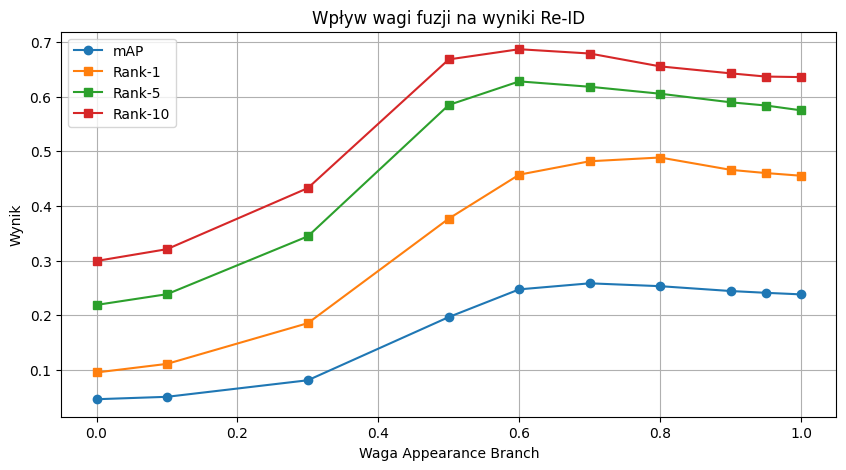

In [14]:
import matplotlib.pyplot as plt

weights = [x[4] for x in results]
maps = [x[0] for x in results]
rank1 = [x[1] for x in results]
rank5 = [x[2] for x in results]
rank10 = [x[3] for x in results]

plt.figure(figsize=(10, 5))
plt.plot(weights, maps, marker='o', label='mAP')
plt.plot(weights, rank1, marker='s', label='Rank-1')
plt.plot(weights, rank5, marker='s', label='Rank-5')
plt.plot(weights, rank10, marker='s', label='Rank-10')
plt.xlabel('Waga Appearance Branch')
plt.ylabel('Wynik')
plt.title('Wpływ wagi fuzji na wyniki Re-ID')
plt.grid(True)
plt.legend()
plt.show()